# Task 2
## Question 1

Importing all the dependencies:

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import tsfel
import matplotlib.pyplot as plt
import seaborn as sns

Extracting the Train and Test Dataset from the Combined Folder:

In [5]:
time = 10 # Setting the time window for each sample
offset = 1000 # Skipping the first 1000 rows to remove noise

folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

combined_dir = "Combined"

X_train=[]
y_train=[]
dataset_dir = os.path.join(combined_dir,"Train")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))

    for file in files:

        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_train.append(df.values)
        y_train.append(classes[folder])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test=[]
y_test=[]
dataset_dir = os.path.join(combined_dir,"Test")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))
    for file in files:

        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_test.append(df.values)
        y_test.append(classes[folder])

X_test = np.array(X_test)
y_test = np.array(y_test)

# concatenating the training and testing data
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))

# splitting the data into training and testing sets.
seed = 4
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=seed,stratify=y)

print("Training data shape: ", X_train.shape) # (number of samples, number of time steps, number of features)
print("Testing data shape: ", X_test.shape)
print("Training labels shape: ", y_train.shape)
print("Testing labels shape: ", y_test.shape)

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)
Training labels shape:  (126,)
Testing labels shape:  (54,)


In [6]:
# taking the square root of the sum of squares of the x, y, z values for each time step to get the magnitude of the acceleration
# this makes the size of the train data as 126, 500 and similarly for the test data

X_train_reshaped = np.sum(X_train**2, axis=2)
X_test_reshaped = np.sum(X_test**2, axis=2)

print("Training data shape: ", X_train_reshaped.shape)
print("Testing data shape: ", X_test_reshaped.shape)

Training data shape:  (126, 500)
Testing data shape:  (54, 500)


## Question 1.1

Training decision tree classifier on raw data


In [7]:
dtc_dataset = DecisionTreeClassifier()
dtc_dataset.fit(X_train_reshaped, y_train)
y_pred_dataset = dtc_dataset.predict(X_test_reshaped)

acc_dataset = accuracy_score(y_test, y_pred_dataset)
prec_dataset = precision_score(y_test, y_pred_dataset, average='macro')
rec_dataset = recall_score(y_test, y_pred_dataset, average='macro')
conf_mx_dataset = confusion_matrix(y_test, y_pred_dataset)

print()
print("Confusion Matrix:")
print(conf_mx_dataset)
print()
print("Provided Dataset Accuracy:", acc_dataset)
print("Provided Dataset Precision:", prec_dataset)
print("Provided Dataset Recall:", rec_dataset)


Confusion Matrix:
[[6 1 2 0 0 0]
 [0 5 2 1 0 1]
 [2 4 2 1 0 0]
 [0 0 0 4 2 3]
 [0 0 0 2 7 0]
 [0 0 0 1 0 8]]

Provided Dataset Accuracy: 0.5925925925925926
Provided Dataset Precision: 0.5787037037037036
Provided Dataset Recall: 0.5925925925925927


## Question 1.2

Training decision tree model using the features obtained by TSFEL - Time Series Feature Extraction Library

In [ ]:
!pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.6 MB/s eta 0:00:00


In [8]:
X_train_dfs = []

for sample in X_train:
  df = pd.DataFrame(sample, columns=["accx", "accy", "accz"])
  reshaped_df = pd.DataFrame(np.sum(sample**2, axis=1), columns=["magnitude"])
  X_train_dfs.append(reshaped_df)

X_test_dfs = []

for sample in X_test:
  df = pd.DataFrame(sample, columns=["accx", "accy", "accz"])
  reshaped_df = pd.DataFrame(np.sum(sample**2, axis=1), columns=["magnitude"])
  X_test_dfs.append(reshaped_df)

# we will be using the default tsfel configuration for the features
tsfel_config = tsfel.get_features_by_domain()

X_train_tsfel_dfs = []
for df in X_train_dfs:
    # since our accelerometer data is sampled at 50Hz, we need to tell TSFEL that the sampling frequency is 50Hz
    feature_df = tsfel.time_series_features_extractor(tsfel_config, df, fs=50)
    X_train_tsfel_dfs.append(feature_df)

In [ ]:
# fill NaN values with 0 to ensure the array is compatible with scikit-learn
X_train_tsfel = pd.concat(X_train_tsfel_dfs, axis=0).fillna(0).values

In [ ]:
# same for X_test
X_test_tsfel_dfs = []
for df in X_test_dfs:
    feature_df = tsfel.time_series_features_extractor(tsfel_config, df, fs=50)
    X_test_tsfel_dfs.append(feature_df)

X_test_tsfel = pd.concat(X_test_tsfel_dfs, axis=0).fillna(0).values

In [ ]:
# merging the list of dataframes into a single dataframe
col = X_train_tsfel_dfs[0].columns
X_train_tsfel_df = pd.DataFrame(X_train_tsfel, columns=col)
X_test_tsfel_df = pd.DataFrame(X_test_tsfel, columns=col)


# If a feature has only one unique value, it is constant across all training samples
# meaning it provides no information, so we drop it
for col in X_train_tsfel_df.columns:
    if len(X_train_tsfel_df[col].unique()) == 1:
        X_train_tsfel_df.drop(col, axis=1, inplace=True)


# some columns are highly correlated, we can remove them because they don't provide any additional information
# removing highly correlated features (columns) from the training data which have a correlation greater than 0.9
corr = X_train_tsfel_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
tri_df = corr.mask(mask)
to_drop = [c for c in tri_df.columns if any(
    tri_df[c] > 0.9)]  # threshold = 0.9
X_train_tsfel_df.drop(columns=to_drop, inplace=True)

# remove the same columns from the test data
X_test_tsfel_df = X_test_tsfel_df[X_train_tsfel_df.columns]

Training the Decision Tree:

In [ ]:
X_train_tsfel_values = X_train_tsfel_df.values
X_test_tsfel_values = X_test_tsfel_df.values

dtc_tsfel = DecisionTreeClassifier()
dtc_tsfel.fit(X_train_tsfel_values, y_train)
y_pred_tsfel = dtc_tsfel.predict(X_test_tsfel_values)

acc_tsfel = accuracy_score(y_test, y_pred_tsfel)
prec_tsfel = precision_score(y_test, y_pred_tsfel, average='macro')
rec_tsfel = recall_score(y_test, y_pred_tsfel, average='macro')
conf_mx_tsfel = confusion_matrix(y_test, y_pred_tsfel)

print("Confusion Matrix:")
print(conf_mx_tsfel)
print()
print("TSFEL Accuracy:", acc_tsfel)
print("TSFEL Precision:", prec_tsfel)
print("TSFEL Recall:", rec_tsfel)

Confusion Matrix:
[[7 2 0 0 0 0]
 [1 7 1 0 0 0]
 [0 2 7 0 0 0]
 [0 0 0 6 2 1]
 [0 0 0 2 7 0]
 [0 0 0 3 0 6]]

TSFEL Accuracy: 0.7407407407407407
TSFEL Precision: 0.761123136123136
TSFEL Recall: 0.7407407407407408


## Question 1.3

Using processed dataset provided by the author which contains 561 features

In [ ]:
raw_data_dir = "UCI HAR Dataset"

X_train_561 = pd.read_csv(os.path.join(raw_data_dir, "train", "X_train.txt"), sep=r'\s+', header=None)
X_test_561 = pd.read_csv(os.path.join(raw_data_dir, "test", "X_test.txt"), sep=r'\s+', header=None)

y_train_561 = pd.read_csv(os.path.join(raw_data_dir, "train", "y_train.txt"), header=None)
y_test_561 = pd.read_csv(os.path.join(raw_data_dir, "test", "y_test.txt"), header=None)

# now train the decision tree classifier
dtc_561 = DecisionTreeClassifier()
dtc_561.fit(X_train_561, y_train_561)
y_pred_561 = dtc_561.predict(X_test_561)

acc_561 = accuracy_score(y_test_561, y_pred_561)
# since, this model is using the provided dataset which is imbalanced, we will use weighted average for precision and recall
prec_561 = precision_score(y_test_561, y_pred_561, average='weighted')
rec_561 = recall_score(y_test_561, y_pred_561, average='weighted')

conf_mx_561 = confusion_matrix(y_test_561, y_pred_561)


print("Confusion Matrix:")
print(conf_mx_561)
print()
print("561 Dataset Accuracy:", acc_561)
print("561 Dataset Precision:", prec_561)
print("561 Dataset Recall:", rec_561)

Confusion Matrix:
[[435  38  23   0   0   0]
 [ 73 369  29   0   0   0]
 [ 15  52 353   0   0   0]
 [  0   0   0 376 115   0]
 [  0   0   0  79 453   0]
 [  0   0   0   0   0 537]]

561 Dataset Accuracy: 0.8561248727519511
561 Dataset Precision: 0.8565667922884035
561 Dataset Recall: 0.8561248727519511


**Observation**

The best performance was achieved using the author's provided dataset (561 features), followed by the TSFEL-based model, while the raw accelerometer data performed the worst.

Reasoning:

* TSFEL improves over raw data by extracting informative features that enhance model learning.

* The provided dataset performs best because it includes more detailed features generated from overlapping sliding windows, offering richer input per sample.

## Question 2

Training the Decision Tree with varying depths (2-8) using all above 3 methods and then plotting the accuracy of the model on test data vs the depth of the tree.

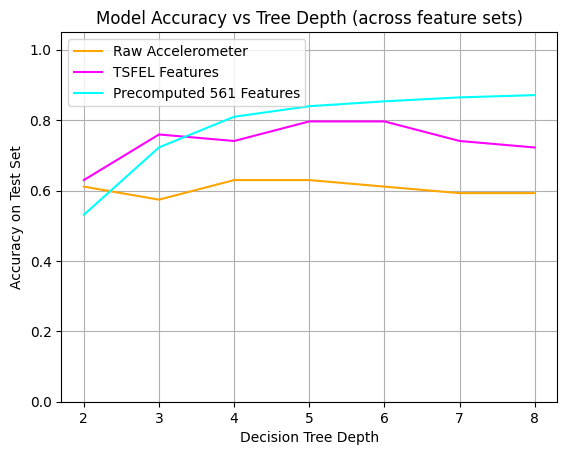

In [ ]:
# Accuracy score lists for three data variants
accuracy_raw = []
accuracy_tsfel = []
accuracy_engineered = []

# Tree depth values to evaluate
tree_depths = range(2, 9)

# Raw accelerometer data
for d in tree_depths:
    model_raw = DecisionTreeClassifier(max_depth=d)
    model_raw.fit(X_train_reshaped, y_train)
    predictions_raw = model_raw.predict(X_test_reshaped)
    accuracy_raw.append(accuracy_score(y_test, predictions_raw))

# TSFEL extracted features
for d in tree_depths:
    model_tsfel = DecisionTreeClassifier(max_depth=d)
    model_tsfel.fit(X_train_tsfel_values, y_train)
    predictions_tsfel = model_tsfel.predict(X_test_tsfel_values)
    accuracy_tsfel.append(accuracy_score(y_test, predictions_tsfel))

# Author provided 561 feature dataset
for d in tree_depths:
    model_prebuilt = DecisionTreeClassifier(max_depth=d)
    model_prebuilt.fit(X_train_561, y_train_561)
    predictions_prebuilt = model_prebuilt.predict(X_test_561)
    accuracy_engineered.append(accuracy_score(y_test_561, predictions_prebuilt))

plt.plot(tree_depths, accuracy_raw, label='Raw Accelerometer', color="orange")
plt.plot(tree_depths, accuracy_tsfel, label='TSFEL Features', color="magenta")
plt.plot(tree_depths, accuracy_engineered, label='Precomputed 561 Features', color="cyan")
plt.xlabel('Decision Tree Depth')
plt.ylabel('Accuracy on Test Set')
plt.title('Model Accuracy vs Tree Depth (across feature sets)')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.show()

## Question 3

Checking if there are any participants/activities where the Model performace is bad.

In [ ]:
# Mapping the activity labels
activity_labels = {
    1: "WALKING",
    2: "WALKING UPSTAIRS",
    3: "WALKING DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

# Computing per-class metrics using TSFEL model predictions
precision_per_class = precision_score(y_test, predictions_tsfel, average=None, labels=list(activity_labels.keys()))
recall_per_class = recall_score(y_test, predictions_tsfel, average=None, labels=list(activity_labels.keys()))
f1_per_class = f1_score(y_test, predictions_tsfel, average=None, labels=list(activity_labels.keys()))

for idx, (prec, rec, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    activity = activity_labels[idx + 1]
    print(f"Activity: {activity}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}\n")

Activity: WALKING
Precision: 0.9000
Recall:    1.0000
F1 Score:  0.9474

Activity: WALKING UPSTAIRS
Precision: 0.7778
Recall:    0.7778
F1 Score:  0.7778

Activity: WALKING DOWNSTAIRS
Precision: 0.8750
Recall:    0.7778
F1 Score:  0.8235

Activity: SITTING
Precision: 0.4286
Recall:    0.6667
F1 Score:  0.5217

Activity: STANDING
Precision: 0.6667
Recall:    0.4444
F1 Score:  0.5333

Activity: LAYING
Precision: 0.8571
Recall:    0.6667
F1 Score:  0.7500



**Observation:**

The model performs very well on dynamic activities like Walking and Walking Downstairs, with high precision and recall.

However, it struggles on static activities like Sitting and Standing, indicating confusion between these similar postures with an F1 < 0.55.

**Why we think so this is happening?**

The accelerometer data during SITTING can look very similar to STANDING or even LAYING, especially if the phone is in a pocket or lying still, thus leading to more confusion!

# Task 3

## Question 1

Pre-Processing on our manual Data:

In [21]:
offset = 100

custom_data_dir = os.path.join("Manual Data Collection")

X_custom_data=[]
y_custom_data=[]

for folder in folders:
    files = os.listdir(os.path.join(custom_data_dir,folder))

    for file in files:

        df = pd.read_csv(os.path.join(custom_data_dir,folder,file),sep=",",header=0)
        df.drop(["time", "TgF"], axis=1, inplace=True)

        df = df[offset:offset+500]

        for col in df.columns:
            df[col] = (2 * (df[col] - df[col].min()) / (df[col].max() - df[col].min())) - 1

        X_custom_data.append(df.values)
        y_custom_data.append(classes[folder])

seed = 4
X_train_custom_data, X_test_custom_data, y_train_custom_data, y_test_custom_data = train_test_split(X_custom_data,y_custom_data,test_size=0.3,random_state=seed,stratify=y_custom_data)

X_train_custom_data = np.array(X_train_custom_data)
X_test_custom_data = np.array(X_test_custom_data)

X_train_custom_data_reshaped = np.sum(X_train_custom_data**2, axis=2)
X_test_custom_data_reshaped = np.sum(X_test_custom_data**2, axis=2)

Previously Trained Decision Tree on Our Data:

In [25]:
y_pred_dataset_custom_data = dtc_dataset.predict(X_test_custom_data_reshaped)
acc_custom_data = accuracy_score(y_test_custom_data, y_pred_dataset_custom_data)

# Since, this model is using a dataset which is balanced, we will use macro average for precision and recall
prec_custom_data = precision_score(y_test_custom_data, y_pred_dataset_custom_data, average='macro', zero_division=0)
rec_custom_data = recall_score(y_test_custom_data, y_pred_dataset_custom_data, average='macro', zero_division=0)

conf_mx_custom_data = confusion_matrix(y_test_custom_data, y_pred_dataset_custom_data)

print("Accuracy:", acc_custom_data)
print("Precision:", prec_custom_data)
print("Recall:", rec_custom_data)
print()
print("Confusion Matrix:")
print(conf_mx_custom_data)

Accuracy: 0.3333333333333333
Precision: 0.19999999999999998
Recall: 0.3333333333333333

Confusion Matrix:
[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]]


We used the Decision Tree model trained on raw accelerometer data (dtc_dataset) for testing on our manually collected sensor data.

**Why we chose this version:**

Our manual data collection was performed using similar sensor types (accelerometers), measuring raw signals along the x, y, z axes, ensuring that our test data is similar to the training data of the selected Decision Tree.

We ensured that:

The data was segmented into fixed time windows (e.g., 500 rows)

The input format was identical to what the raw model was trained on (shape: 500 * 3)

## Task 3 Question 2

Using the Data we collected to predict the activities that we did:

Approach:
Train a new Decision Tree on the Custom Training Data and test it on the Custom Testing Data. The data was splitted and preprocessed during the above preprocessing already.

In [29]:
# Train the model
dtc_custom = DecisionTreeClassifier()
dtc_custom.fit(X_train_custom_data_reshaped, y_train_custom_data)

# Predict on test set
y_pred_custom = dtc_custom.predict(X_test_custom_data_reshaped)

# Evaluate
accuracy = accuracy_score(y_test_custom_data, y_pred_custom)
precision = precision_score(y_test_custom_data, y_pred_custom, average='macro', zero_division=0)
recall = recall_score(y_test_custom_data, y_pred_custom, average='macro', zero_division=0)
conf_matrix = confusion_matrix(y_test_custom_data, y_pred_custom)

# Display results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print()
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.5
Precision: 0.3055555555555555
Recall: 0.5


Confusion Matrix:
 [[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


We applied basic preprocessing by:

* Dropping irrelevant columns (time, TgF)

* Normalizing each axis (acc_x, acc_y, acc_z) to the range [-1, 1]

This gave us a simple, noise-resistant feature representation.

Next, as we can see the model shows moderate accuracy, but low precision indicates that it mislabels several classes.
Using only raw total acceleration may not capture enough distinctive features and thus more advanced featurization (like TSFEL) could improve class separation.
